# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = f"/content/drive/My Drive/ml/edyo/project/dataset"
output_path = f"/content/drive/My Drive/ml/edyo/project/output/sprint2"

In [ ]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

In [ ]:
summary_df = pd.read_csv(f"{output_path}/summary.csv")
summary_df["person_name"].value_counts()[:20]

Hanna Shubina            6570
Naomi_Watts               214
Dick_Cheney               121
James_Blake                98
John_Ashcroft              80
John_Eder                  48
Kathryn_Bigelow            48
Jonathan_Karsh             40
Don_Nickles                29
Florencia_Macri            23
Paddy_Long                 23
Martin_McGuinness          23
Alvaro_Silva_Calderon      18
James_Kelly                16
Victor_Kraatz              14
Teresa_Worbis              13
Monica_Bellucci            12
John_Negroponte            11
Jeff_Feldman               10
Michael_Wayne               7
Name: person_name, dtype: int64

In [ ]:
annotations_df = pd.read_csv(f"{dataset_path}/Milestone 1 - Dataset.csv")
annotated_df = annotations_df[annotations_df.iloc[:, 1].notna()]

In [ ]:
dataset_df = annotated_df.iloc[1:, [0,2,3,4,5,6,7,8,9,10,11,12]].copy()
dataset_df.columns = ["video_name", "person_name", "no_face", "one_face", "multiple_faces",
                      "dark", "normal_light", "light",
                      "visible", "not_facing_camera", "mask", "occluded"]
dataset_df.reset_index(drop=True, inplace=True)

one_face = dataset_df["no_face"].isna() & dataset_df["one_face"].notna() & dataset_df["multiple_faces"].isna()

# Description

Previously, we check face recognition tools for "ideal" cases e.g. person's face is visible, normal lighting conditions etc. Now we are interested in abnormal typical cases like face is covered or room is dark.


1. Check face detection quality for:
    - normal cases
    - face is covered by mask or traditional clothes
    - abnormal light conditions
    
2. Check face recognition quality for:
    - normal cases
    - face is covered by mask or traditional clothes
    - abnormal light conditions
    
3. Face detection and recognition quality improvement.

# Face detection and recognition analysis

Dataset: https://drive.google.com/drive/folders/1WK6WrvrwhtXKsRJO2H_f2rS6sETghcQB?usp=sharing  

To simplify accuracy measurement process we selected videos with only one person without cases of disappering from the camera.
 
Dataset contains cases with face mask and abnormal light conditions.

---

Number of videos: 120  
Duration: ~15s  
Resolutions: 960x540 

---

In [ ]:
# @title
pd.set_option('display.precision', 2)

def process_output(video_list, summary_df, dataset_df, title):
    output_df = pd.DataFrame([], columns=["wrong_face_detection_%", "wrong_face_recognition_%"])
    
    for video_name in video_list:
        selected_df = summary_df[summary_df["frame_path"].str.startswith(video_name)]
        processed_frames = len(selected_df)
        person_name = dataset_df[dataset_df["video_name"] == video_name]["person_name"].iloc[0]
        
        wrong_face_detection = len(selected_df[selected_df["num_faces"] != 1])
        wrong_face_recognition = len(selected_df[selected_df["person_name"] != person_name])
        
        output_df = output_df.append({"wrong_face_detection_%": wrong_face_detection/processed_frames*100, 
                                        "wrong_face_recognition_%": wrong_face_recognition/processed_frames*100}, 
                                       ignore_index=True)
#     output_df = output_df.agg({'wrong_face_detection_%': ['mean', 'count'],
#                                'wrong_face_recognition_%': ['mean', 'count']})
    output_df = output_df.mean().to_frame()#.describe()
    output_df.columns = ["mean"]
    return output_df.style.set_caption(f"{title}: {len(video_list)} videos")

def display_gif(file_path):
    with open(file_path,'rb') as f:
        return display.Image(data=f.read(), format='png', width="500")

In [ ]:
# @title
one_person_only_list = dataset_df[one_face]["video_name"].unique()

process_output(one_person_only_list, summary_df, dataset_df, "One person")

,mean
wrong_face_detection_%,22.32
wrong_face_recognition_%,48.33


## Normal cases 

In [ ]:
# @title
display_gif(f"{output_path}/gif/medium_video_1_0000.mp4.gif")
display_gif(f"{output_path}/gif/medium_video_3_0035.mp4.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title
normal_list = dataset_df[one_face & dataset_df["normal_light"].notna() 
                         & dataset_df["mask"].isna()
                         & dataset_df["occluded"].isna()]["video_name"].unique()

process_output(normal_list, summary_df, dataset_df, "One person")

,mean
wrong_face_detection_%,0.66
wrong_face_recognition_%,3.46


## Face mask

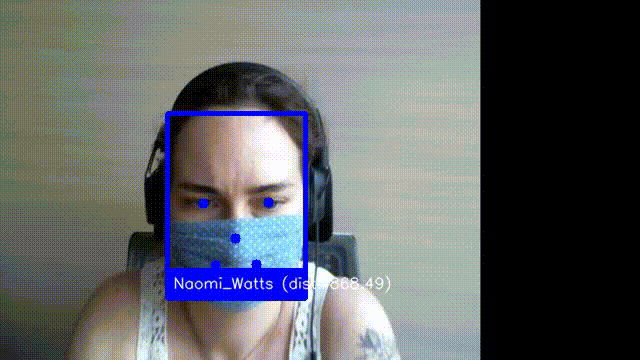

In [ ]:
# @title
display_gif(f"{output_path}/gif/medium_video_3_0001.mp4.gif")

In [ ]:
# @title
mask_video_list = dataset_df[dataset_df["no_face"].isna() 
                             & dataset_df["multiple_faces"].isna()
                             & dataset_df["mask"].notna()]["video_name"].unique()

process_output(mask_video_list, summary_df, dataset_df, "Mask")

,mean
wrong_face_detection_%,13.04
wrong_face_recognition_%,97.10


## Abnormal light conditions

In [ ]:
# @title
display_gif(f"{output_path}/gif/medium_video_4_0000.mp4.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title
dark_video_list = dataset_df[dataset_df["no_face"].isna() 
                             & dataset_df["multiple_faces"].isna()
                             & dataset_df["dark"].notna()]["video_name"].unique()

process_output(dark_video_list, summary_df, dataset_df, "Dark")

,mean
wrong_face_detection_%,83.33
wrong_face_recognition_%,99.65


# Face recognition quality improvement

## Dataset augmentation

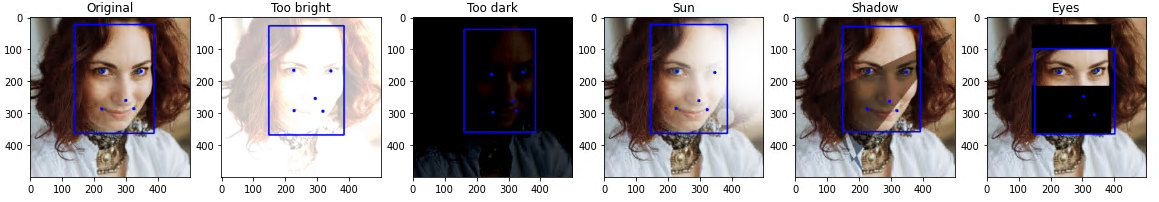

| Method | Correct recognition |
|---|---|
|Without augmentations|87.38%|
|All augmentations applied|66.35%|
|"Eyes"|59.08%|
|"Eyes"+"Sun"+"Shadow"|61.38%|
|"Sun"+"Shadow"|70.26%|
|"Shadow"|85.53%|

Detailed results: https://docs.google.com/spreadsheets/d/1AMO2kSDkpFSfy-8hbW-Nbjx7UF89tQd-xU2sCX4yhwc/edit?usp=sharing

## NN search algorithms

Finding the closest face features embedding is long operation, so approximate algorithms are used.

Similarity search tools were tested:  
[Faiss](https://github.com/facebookresearch/faiss)  
[Spotify Annoy ](https://github.com/spotify/annoy)  
[nmslib](https://github.com/nmslib/nmslib)  

| Tool | Correct recognition |
|---|---|
|faiss|87.38%|
|annoy|87.38%|
|mnslib|0%|

# Summary

1. For abnormal conditions we've got poor detection and recognition accuracy.
2. Populating dataset with augmented photos corresponding to abnormal cases didn't increase the recognition accuracy.
3. Similarity search tools isn't th way for increasing accuracy. Faiss easily allows us to update the index file with new elements, while other tools require rebuilding the index.

# What's next

1. Move to next task (integration with app).
2. Find tools for specific cases like covered face.